In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:

import hdbscan


class DemographicClusterer:
    def __init__(self, data_path=None, df=None):
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(data_path)
        
        self.processed_data = None
        self.cluster_results = {}
        self.preprocessing_info = {}
        
    def preprocess_data(self, categorical_cols=None, numerical_cols=None):
        """
        Handle mixed data types for clustering
        """
        print("Starting data preprocessing...")
        
        if categorical_cols is None:
            categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()
        if numerical_cols is None:
            numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        self.preprocessing_info['categorical_cols'] = categorical_cols
        self.preprocessing_info['numerical_cols'] = numerical_cols
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
            ])
        
        self.processed_data = preprocessor.fit_transform(self.df)
        self.preprocessor = preprocessor
        
        # Get feature names after preprocessing
        num_features = numerical_cols
        cat_features = []
        if len(categorical_cols) > 0:
            cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        
        self.feature_names = num_features + list(cat_features)
        
        print(f"Data shape after preprocessing: {self.processed_data.shape}")
        print(f"Features: {len(self.feature_names)} total")

        # Apply PCA if requested
        print("Applying PCA for dimensionality reduction...")
        self.pca = PCA()
        pca_data = self.pca.fit_transform(self.processed_data)
        
        # Determine number of components based on variance threshold
        cumsum_var = np.cumsum(self.pca.explained_variance_ratio_)
        n_components = np.argmax(cumsum_var >= 0.95) + 1
        
        print(f"PCA: Using {n_components} components explaining {cumsum_var[n_components-1]:.1%} of variance")
        
        # Refit with optimal components
        self.pca = PCA(n_components=n_components)
        self.processed_data = self.pca.fit_transform(self.processed_data)
        
        self.pca_feature_names = [f'PC{i+1}' for i in range(n_components)]
        
        print(f"Final processed data shape: {self.processed_data.shape}")

        return self.processed_data
    
    def find_optimal_clusters(self, max_clusters=10):
        """
        Use elbow method and silhouette analysis to find optimal number of clusters
        """
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=500)
            labels = kmeans.fit_predict(self.processed_data)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(self.processed_data, labels)
            silhouette_scores.append(sil_score)
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Analysis')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Suggest optimal k
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Suggested optimal number of clusters: {optimal_k}")
        return optimal_k
    
    def apply_clustering_methods(self, n_clusters=4):
        """
        Apply different clustering algorithms
        """
        methods = {
            'HDBSCAN': hdbscan.HDBSCAN(min_cluster_size=max(300, len(self.processed_data) // 40),  # Adaptive min size
                                            min_samples=20,
                                            cluster_selection_epsilon=0.2,
                                            # cluster_selection_method='leaf'
                                        ),
            'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=500),
            'Hierarchical': AgglomerativeClustering(n_clusters=n_clusters),
            'Gaussian Mixture': GaussianMixture(n_components=n_clusters, random_state=42, covariance_type='full'),
            'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
        }
        
        results = {}
        
        for name, model in methods.items():
            print(f"Applying {name}...")
            
            if name == 'Gaussian Mixture':
                model.fit(self.processed_data)
                labels = model.predict(self.processed_data)
            else:
                labels = model.fit_predict(self.processed_data)
            
            # Calculate metrics
            if len(np.unique(labels)) > 1:  # Avoid error when only one cluster
                sil_score = silhouette_score(self.processed_data, labels)
                ch_score = calinski_harabasz_score(self.processed_data, labels)
            else:
                sil_score = -1
                ch_score = 0
            
            results[name] = {
                'model': model,
                'labels': labels,
                'n_clusters': len(np.unique(labels)),
                'silhouette_score': sil_score,
                'calinski_harabasz_score': ch_score
            }
        
        self.cluster_results = results
        return results
    
    def evaluate_clusters(self):
        """
        Compare clustering methods and show evaluation metrics
        """
        print("\n" + "="*60)
        print("CLUSTERING EVALUATION RESULTS")
        print("="*60)
        
        evaluation_df = []
        
        for method, result in self.cluster_results.items():
            evaluation_df.append({
                'Method': method,
                'Clusters': result['n_clusters'],
                'Silhouette Score': f"{result['silhouette_score']:.3f}",
                'Calinski-Harabasz Score': f"{result['calinski_harabasz_score']:.1f}"
            })
        
        eval_df = pd.DataFrame(evaluation_df)
        print(eval_df.to_string(index=False))
        
        # Recommend best method
        valid_methods = {k: v for k, v in self.cluster_results.items() 
                        if v['silhouette_score'] > 0}
        
        if valid_methods:
            best_method = max(valid_methods.keys(), 
                            key=lambda x: valid_methods[x]['silhouette_score'])
            print(f"\nRecommended method: {best_method}")
            print(f"Silhouette Score: {valid_methods[best_method]['silhouette_score']:.3f}")
        
        return eval_df
    
    def create_tsne_visualization(self, method='HDBSCAN', perplexity=30):
        """
        Create t-SNE visualization of clusters
        """
        if method not in self.cluster_results:
            print(f"Method {method} not found in results")
            return
        
        print(f"Creating t-SNE visualization for {method}...")
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        tsne_data = tsne.fit_transform(self.processed_data)
        
        labels = self.cluster_results[method]['labels']
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], 
                            c=labels, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter)
        plt.title(f't-SNE Visualization - {method}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        
        # Add cluster centers if available
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = labels == label
            center_x = np.mean(tsne_data[mask, 0])
            center_y = np.mean(tsne_data[mask, 1])
            plt.annotate(f'C{label}', (center_x, center_y), 
                        fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    def create_cluster_profiles(self, method='HDBSCAN'):
        """
        Create detailed cluster profiles showing characteristics
        """
        if method not in self.cluster_results:
            print(f"Method {method} not found in results")
            return
        
        labels = self.cluster_results[method]['labels']
        df_with_clusters = self.df.copy()
        df_with_clusters['Cluster'] = labels
        
        print(f"\n{'='*50}")
        print(f"CLUSTER PROFILES - {method}")
        print(f"{'='*50}")
        
        # Numerical features analysis
        numerical_cols = self.preprocessing_info['numerical_cols']
        if numerical_cols:
            print("\nNumerical Features by Cluster:")
            numerical_stats = df_with_clusters.groupby('Cluster')[numerical_cols].agg(['mean', 'std'])
            print(numerical_stats.round(2))
        
        # Categorical features analysis
        categorical_cols = self.preprocessing_info['categorical_cols']
        if categorical_cols:
            print("\nCategorical Features Distribution by Cluster:")
            for col in categorical_cols:
                print(f"\n{col.upper()}:")
                crosstab = pd.crosstab(df_with_clusters['Cluster'], 
                                     df_with_clusters[col], normalize='index')
                print((crosstab * 100).round(1).to_string())
        
        return df_with_clusters
    
    def create_radial_charts(self, method='K-Means', sample_features=None):
        """
        Create radial/radar charts for cluster comparison
        """
        if method not in self.cluster_results:
            print(f"Method {method} not found in results")
            return
        
        labels = self.cluster_results[method]['labels']
        df_with_clusters = self.df.copy()
        df_with_clusters['Cluster'] = labels
        
        # Select features for radial chart
        numerical_cols = self.preprocessing_info['numerical_cols']
        if sample_features is None:
            sample_features = numerical_cols[:6]  # Limit to 6 features for readability
        
        if not sample_features:
            print("No numerical features available for radial chart")
            return
        
        # Calculate means for each cluster
        cluster_means = df_with_clusters.groupby('Cluster')[sample_features].mean()
        
        # Normalize values to 0-1 scale for better visualization
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        normalized_means = pd.DataFrame(
            scaler.fit_transform(cluster_means),
            columns=cluster_means.columns,
            index=cluster_means.index
        )
        
        # Create radial charts
        n_clusters = len(normalized_means)
        fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5), 
                               subplot_kw=dict(projection='polar'))
        
        if n_clusters == 1:
            axes = [axes]
        
        angles = np.linspace(0, 2*np.pi, len(sample_features), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
        
        for idx, (cluster_id, cluster_data) in enumerate(normalized_means.iterrows()):
            values = cluster_data.tolist()
            values += values[:1]  # Complete the circle
            
            ax = axes[idx]
            ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
            ax.fill(angles, values, alpha=0.25, color=colors[idx])
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(sample_features)
            ax.set_ylim(0, 1)
            ax.set_title(f'Cluster {cluster_id}', size=14, weight='bold', pad=20)
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def create_comparison_heatmap(self, method='K-Means'):
        """
        Create heatmap showing cluster characteristics
        """
        if method not in self.cluster_results:
            print(f"Method {method} not found in results")
            return
        
        labels = self.cluster_results[method]['labels']
        df_with_clusters = self.df.copy()
        df_with_clusters['Cluster'] = labels
        
        # Get numerical features means by cluster
        numerical_cols = self.preprocessing_info['numerical_cols']
        if not numerical_cols:
            print("No numerical features for heatmap")
            return
        
        cluster_means = df_with_clusters.groupby('Cluster')[numerical_cols].mean()
        
        # Normalize for better visualization
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(cluster_means.T).T
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(normalized_data, 
                   xticklabels=numerical_cols,
                   yticklabels=[f'Cluster {i}' for i in cluster_means.index],
                   annot=True, fmt='.2f', cmap='RdYlBu_r', center=0)
        plt.title(f'Cluster Characteristics Heatmap - {method}')
        plt.tight_layout()
        plt.show()


In [3]:
datapath = "/Users/whysocurious/Documents/MLDSAIProjects/cust-seg-case-study/data"
dfcust = pd.read_csv(datapath+'/customer_data_imputed.csv').set_index('Customer ID')
#(datapath+'/Customer Segmentation.csv')
print (f"Data shape: {dfcust.shape}")
print (f"Data columns: {dfcust.columns.tolist()}")
print (f"Data types:\n{dfcust.dtypes}")
print (f"Missing values:\n{dfcust.isnull().sum()}")
# dfcust.head()


Data shape: (8363, 8)
Data columns: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size']
Data types:
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
dtype: object
Missing values:
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64


In [4]:
profession_mapping = {
            'Doctor': 'High-Skill', 'Engineer': 'High-Skill', 'Executive': 'High-Skill', 
            'Lawyer': 'High-Skill',
            'Artist': 'Creative', 'Entertainment': 'Creative',
            'Healthcare': 'Service/Care', 'Homemaker': 'Service/Care',
            'Marketing': 'Business-Oriented'
        }

dfcust['profession_category'] = dfcust['Profession'].map(profession_mapping)

def determine_life_stage(row):
    age = row.get('Age', 0)
    exp = row.get('Work_Experience', 0)
    marital = row.get('Ever_Married', 'Unknown')
    
    if age < 25:
        return 'Career Starter'
    elif 22 <= age <= 35 and marital in ['No'] and exp <= 3:
        return 'Young Professional'
    elif 30 <= age <= 50 and marital == 'Yes' and exp > 3:
        return 'Established Adult'
    elif age >= 60:
        return 'Senior Segment'
    else:
        return 'Transitional'

dfcust['life_stage'] = dfcust.apply(determine_life_stage, axis=1)

profession_weights = {'High-Skill': 4, 'Business-Oriented': 3, 'Creative': 2, 'Service/Care': 1}
prof_score = dfcust['profession_category'].map(profession_weights).fillna(2) / 4 * 40

education_weights = {'No': 0, 'Yes': 1}
edu_score = dfcust['Graduated'].map(education_weights).fillna(0) * 30

spending_weights = {'Low': 1, 'Average': 2, 'High': 3}
spend_score = dfcust['Spending_Score'].map(spending_weights).fillna(2) / 3 * 30

dfcust['economic_capacity_index'] = prof_score + edu_score + spend_score

age_weight = np.clip(dfcust['Age'] / 70, 0.5, 1.5)  # Age factor           

marital_weight = 1.0
marital_weights = {'Yes': 1.5, 'No': 0.8}
marital_weight = dfcust['Ever_Married'].map(marital_weights)

family_size = 1
family_size = dfcust['Family_Size'].fillna(1)

dfcust['family_responsibility_factor'] = age_weight * marital_weight * family_size


def check_alignment(row):
    prof_cat = row.get('profession_category', '')
    education = row.get('Graduated', '')
    
    if prof_cat == 'High-Skill' and education in ['Yes']:
        return 1
    elif prof_cat in ['Creative', 'Business-Oriented'] and education in ['Yes']:
        return 1
    elif prof_cat == 'Service/Care':
        return 1  # Service roles have varied education requirements
    else:
        return 0

dfcust['profession_education_match'] = dfcust.apply(check_alignment, axis=1)


print (f"Data shape: {dfcust.shape}")
print (f"Data columns: {dfcust.columns.tolist()}")
print (f"Data types:\n{dfcust.dtypes}")
print (f"Missing values:\n{dfcust.isnull().sum()}")

Data shape: (8363, 13)
Data columns: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'profession_category', 'life_stage', 'economic_capacity_index', 'family_responsibility_factor', 'profession_education_match']
Data types:
Gender                           object
Ever_Married                     object
Age                               int64
Graduated                        object
Profession                       object
Work_Experience                 float64
Spending_Score                   object
Family_Size                     float64
profession_category              object
life_stage                       object
economic_capacity_index         float64
family_responsibility_factor    float64
profession_education_match        int64
dtype: object
Missing values:
Gender                          0
Ever_Married                    0
Age                             0
Graduated                       0
Profession                

In [5]:
le_1 = LabelEncoder()
for col in dfcust.columns:
    if dfcust[col].dtype == 'object':
        print (col, dfcust[col].unique())
        dfcust[col] = le_1.fit_transform(dfcust[col])
dfcust.head()
    

Gender ['Male' 'Female']
Ever_Married ['Yes' 'No']
Graduated ['Yes' 'No']
Profession ['Executive' 'Artist' 'Healthcare' 'Lawyer' 'Marketing' 'Engineer'
 'Doctor' 'Entertainment' 'Homemaker']
Spending_Score ['High' 'Average' 'Low']
profession_category ['High-Skill' 'Creative' 'Service/Care' 'Business-Oriented']
life_stage ['Senior Segment' 'Transitional' 'Career Starter' 'Young Professional'
 'Established Adult']


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,profession_category,life_stage,economic_capacity_index,family_responsibility_factor,profession_education_match
Customer ID,,,,,,,,,,,,,
458982,1,1,61,1,4,1.0,1,3.0,2,2,100.0,3.921429,1
458983,0,1,63,1,4,0.0,1,5.0,2,2,100.0,6.750000,1
458984,1,1,39,1,0,0.0,0,3.0,1,3,70.0,2.507143,1
458985,1,0,23,0,5,1.0,2,4.0,3,0,20.0,1.600000,1
458986,1,0,18,0,5,7.0,2,4.0,3,0,20.0,1.600000,1


In [6]:
dfcust.corr().abs().round(2).style.background_gradient(cmap='coolwarm', axis=None, low=0.2, high=0.7)  


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,profession_category,life_stage,economic_capacity_index,family_responsibility_factor,profession_education_match
Gender,1.000000,0.120000,0.030000,0.040000,0.030000,0.070000,0.050000,0.060000,0.020000,0.060000,0.010000,0.100000,0.030000
Ever_Married,0.120000,1.000000,0.570000,0.200000,0.140000,0.110000,0.630000,0.080000,0.260000,0.100000,0.500000,0.570000,0.060000
Age,0.030000,0.570000,1.000000,0.240000,0.040000,0.200000,0.270000,0.290000,0.240000,0.030000,0.520000,0.420000,0.040000
Graduated,0.040000,0.200000,0.240000,1.000000,0.300000,0.030000,0.150000,0.230000,0.280000,0.240000,0.700000,0.010000,0.750000
Profession,0.030000,0.140000,0.040000,0.300000,1.000000,0.020000,0.230000,0.090000,0.450000,0.200000,0.180000,0.000000,0.080000
Work_Experience,0.070000,0.110000,0.200000,0.030000,0.020000,1.000000,0.050000,0.060000,0.040000,0.200000,0.060000,0.170000,0.060000
Spending_Score,0.050000,0.630000,0.270000,0.150000,0.230000,0.050000,1.000000,0.120000,0.220000,0.040000,0.410000,0.510000,0.010000
Family_Size,0.060000,0.080000,0.290000,0.230000,0.090000,0.060000,0.120000,1.000000,0.170000,0.080000,0.170000,0.610000,0.080000
profession_category,0.020000,0.260000,0.240000,0.280000,0.450000,0.040000,0.220000,0.170000,1.000000,0.190000,0.290000,0.090000,0.130000
life_stage,0.060000,0.100000,0.030000,0.240000,0.200000,0.200000,0.040000,0.080000,0.190000,1.000000,0.190000,0.090000,0.010000


In [7]:
categorical_cols=['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size','profession_category','life_stage','profession_education_match']
numerical_cols=['Age']

# Initialize clusterer
clusterer = DemographicClusterer(df=dfcust)

# Preprocess data
clusterer.preprocess_data(categorical_cols=categorical_cols, 
                        numerical_cols=numerical_cols)

# # Find optimal number of clusters
# optimal_k = clusterer.find_optimal_clusters(max_clusters=8)

optimal_k = 7
# Apply different clustering methods
results = clusterer.apply_clustering_methods(n_clusters=optimal_k)

Starting data preprocessing...
Data shape after preprocessing: (8363, 44)
Features: 44 total
Applying PCA for dimensionality reduction...
PCA: Using 25 components explaining 95.5% of variance
Final processed data shape: (8363, 25)
Applying HDBSCAN...
Applying K-Means...
Applying Hierarchical...
Applying Gaussian Mixture...
Applying DBSCAN...


In [8]:
dfpdata = pd.DataFrame(clusterer.processed_data)


In [9]:
results

{'HDBSCAN': {'model': HDBSCAN(cluster_selection_epsilon=0.2, min_cluster_size=300, min_samples=20),
  'labels': array([ 0, -1,  4, ..., -1, -1,  4], shape=(8363,)),
  'n_clusters': 6,
  'silhouette_score': 0.06335044374979926,
  'calinski_harabasz_score': 662.0892673254945},
 'K-Means': {'model': KMeans(max_iter=500, n_clusters=7, n_init=20, random_state=42),
  'labels': array([3, 3, 1, ..., 6, 3, 1], shape=(8363,), dtype=int32),
  'n_clusters': 7,
  'silhouette_score': 0.17647578033560707,
  'calinski_harabasz_score': 1169.0930175103185},
 'Hierarchical': {'model': AgglomerativeClustering(n_clusters=7),
  'labels': array([3, 3, 1, ..., 0, 3, 1], shape=(8363,)),
  'n_clusters': 7,
  'silhouette_score': 0.1586190654292835,
  'calinski_harabasz_score': 1083.2902115386676},
 'Gaussian Mixture': {'model': GaussianMixture(n_components=7, random_state=42),
  'labels': array([0, 0, 4, ..., 6, 0, 1], shape=(8363,)),
  'n_clusters': 7,
  'silhouette_score': 0.146392222396429,
  'calinski_haraba

In [10]:
dfcust['kMeansClust_2'] = results['K-Means']['labels']
print (dfcust['kMeansClust_2'].value_counts())
dfcust.drop('kMeansClust_2', axis=1, inplace=True)
dfcust.head()

kMeansClust_2
1    2439
0    1451
4    1187
6     968
3     943
2     771
5     604
Name: count, dtype: int64


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,profession_category,life_stage,economic_capacity_index,family_responsibility_factor,profession_education_match
Customer ID,,,,,,,,,,,,,
458982,1,1,61,1,4,1.0,1,3.0,2,2,100.0,3.921429,1
458983,0,1,63,1,4,0.0,1,5.0,2,2,100.0,6.750000,1
458984,1,1,39,1,0,0.0,0,3.0,1,3,70.0,2.507143,1
458985,1,0,23,0,5,1.0,2,4.0,3,0,20.0,1.600000,1
458986,1,0,18,0,5,7.0,2,4.0,3,0,20.0,1.600000,1


In [11]:
clusterer.processed_data

array([[ 1.60158678, -0.69605503,  0.1233154 , ..., -0.09341233,
        -0.00180668,  0.03813718],
       [ 1.62993574, -0.68591113,  0.18046357, ...,  0.12927735,
         0.00870202, -0.01893105],
       [-0.02378931,  1.07322957, -0.43380459, ..., -0.0175406 ,
        -0.14632881, -0.0060199 ],
       ...,
       [-1.34481207, -0.15215006, -0.41580578, ..., -0.04820695,
        -0.09626959, -0.15357326],
       [ 1.5942702 , -0.59254967,  0.27895427, ..., -0.06769643,
         0.07045353,  0.03131567],
       [-0.2757843 ,  0.79657255,  0.31623518, ..., -0.07913725,
        -0.05681711, -0.04129361]], shape=(8363, 25))

Creating t-SNE visualization ...


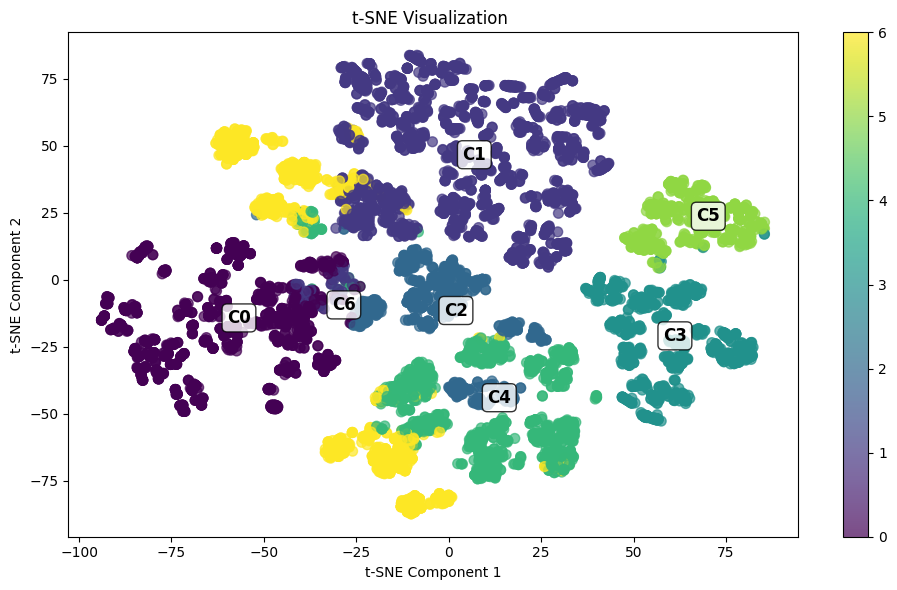

In [12]:
print(f"Creating t-SNE visualization ...")

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_data = tsne.fit_transform(clusterer.processed_data)

labels = results['K-Means']['labels'] #self.cluster_results[method]['labels']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], 
                    c=labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title(f't-SNE Visualization ')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add cluster centers if available
unique_labels = np.unique(labels)
for label in unique_labels:
    mask = labels == label
    center_x = np.mean(tsne_data[mask, 0])
    center_y = np.mean(tsne_data[mask, 1])
    plt.annotate(f'C{label}', (center_x, center_y), 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

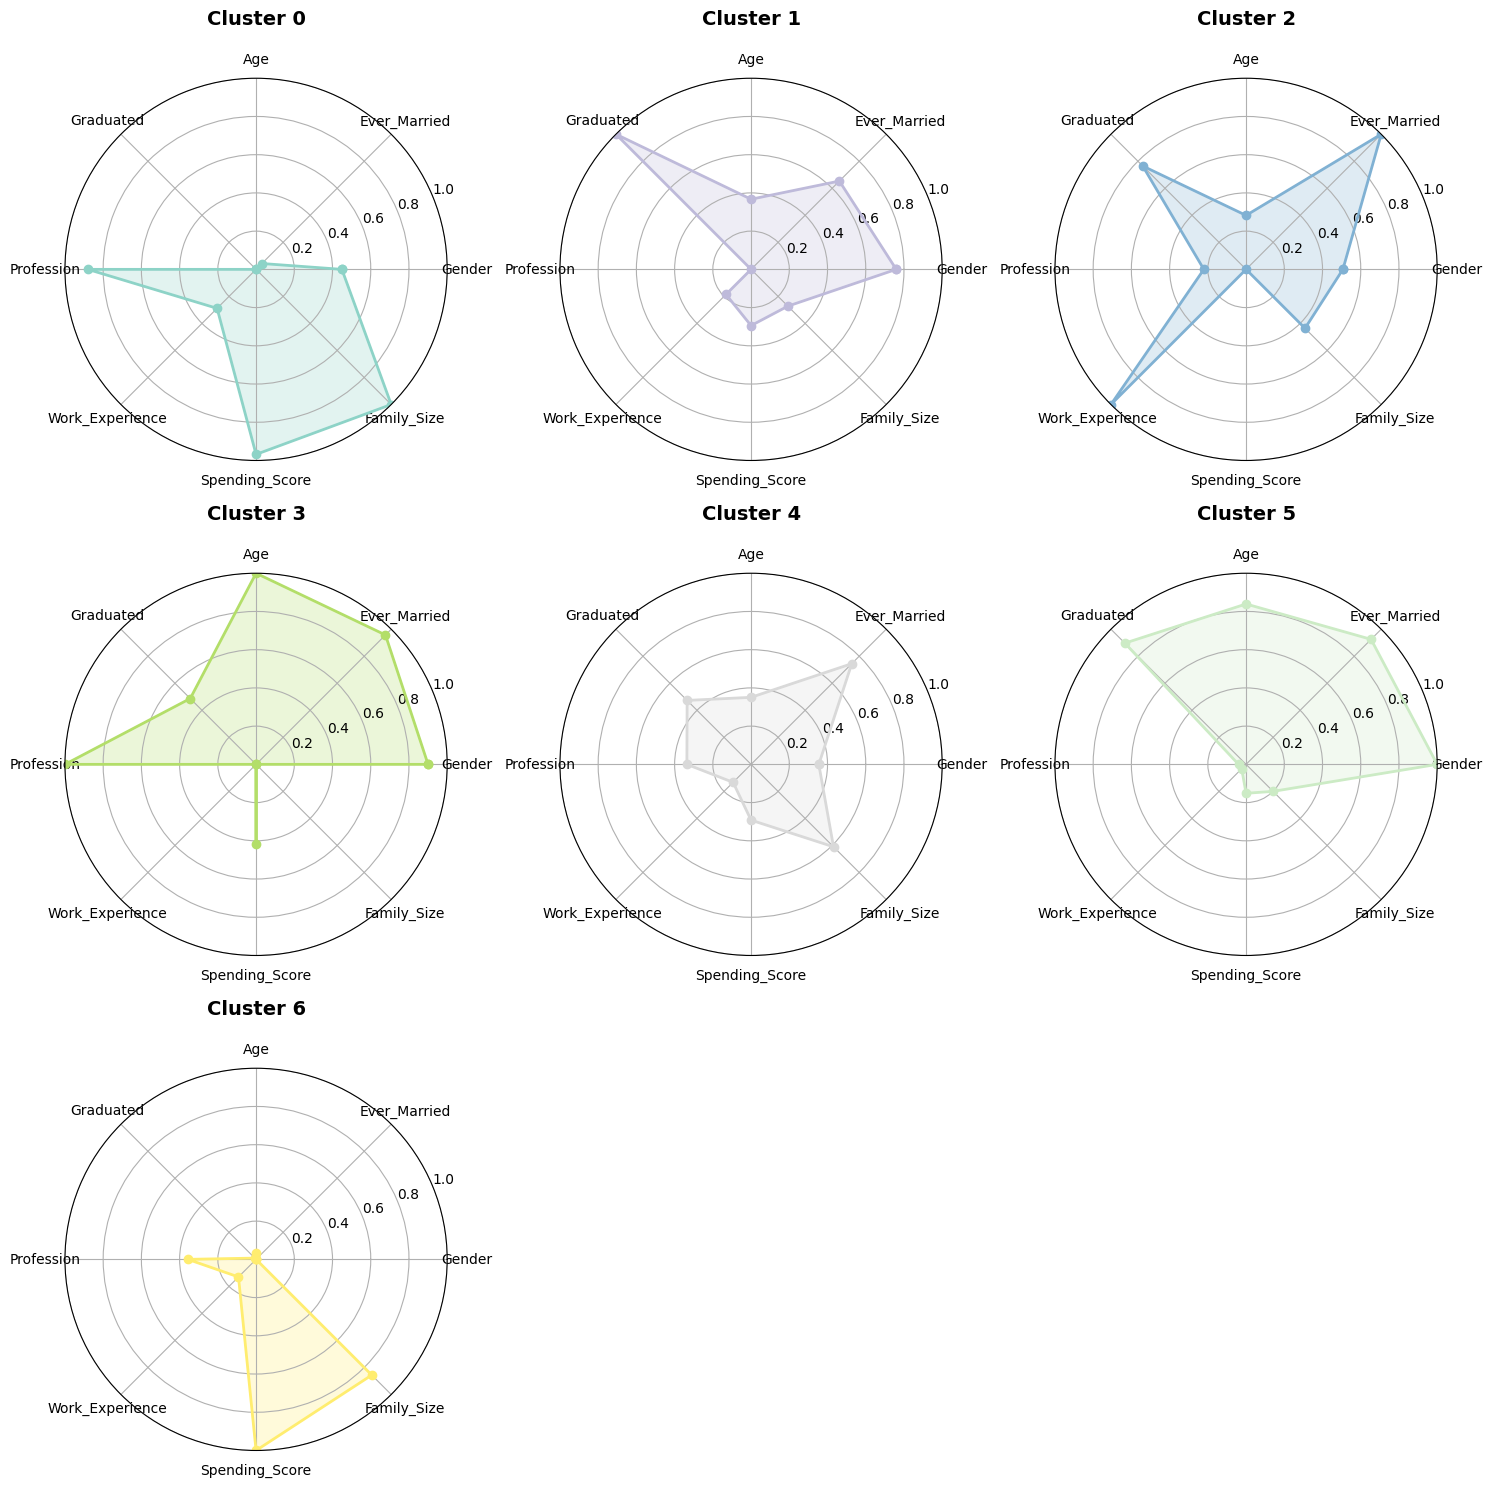

In [13]:
labels = results['K-Means']['labels']
df_with_clusters = dfcust.copy()
df_with_clusters['Cluster'] = labels

# Select features for radial chart
numerical_cols = ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size']
sample_features = numerical_cols#[:6]  # Limit to 6 features for readability

if not sample_features:
    print("No numerical features available for radial chart")

# Calculate means for each cluster
cluster_means = df_with_clusters.groupby('Cluster')[sample_features].mean()

# Normalize values to 0-1 scale for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_means = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Create radial charts with automatic grid layout
n_clusters = len(normalized_means)

# Calculate optimal grid dimensions
if n_clusters <= 3:
    n_rows, n_cols = 1, n_clusters
elif n_clusters <= 6:
    n_rows, n_cols = 2, (n_clusters + 1) // 2
elif n_clusters <= 9:
    n_rows, n_cols = 3, (n_clusters + 2) // 3
else:
    n_rows = int(np.ceil(np.sqrt(n_clusters)))
    n_cols = int(np.ceil(n_clusters / n_rows))

# Adjust figure size based on grid
fig_width = min(5 * n_cols, 20)  # Cap width at 20
fig_height = min(5 * n_rows, 15)  # Cap height at 15

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), 
                        subplot_kw=dict(projection='polar'))

# Handle different cases for axes array structure
if n_clusters == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes if n_cols > 1 else [axes]
else:
    axes = axes.flatten()

angles = np.linspace(0, 2*np.pi, len(sample_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for idx, (cluster_id, cluster_data) in enumerate(normalized_means.iterrows()):
    values = cluster_data.tolist()
    values += values[:1]  # Complete the circle
    
    ax = axes[idx]
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(sample_features)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id}', size=14, weight='bold', pad=20)
    ax.grid(True)

# Hide unused subplots if any
total_subplots = n_rows * n_cols
if n_clusters < total_subplots:
    for i in range(n_clusters, total_subplots):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
dfcust.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size',
       'profession_category', 'life_stage', 'economic_capacity_index',
       'family_responsibility_factor', 'profession_education_match'],
      dtype='object')

In [15]:
print(f"\n{'='*50}")
print(f"CLUSTER PROFILES ")
print(f"{'='*50}")

# Numerical features analysis
# if numerical_cols:
numerical_cols = ['Age', 'economic_capacity_index', 'family_responsibility_factor']
print("\nNumerical Features by Cluster:")
for col in numerical_cols:
    numerical_stats = df_with_clusters.groupby('Cluster')[col].agg(['mean', 'std'])
    print (col)
    print(numerical_stats.round(2))

# Categorical features analysis
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession','Work_Experience', 'Spending_Score', 'Family_Size',
                    'profession_category', 'life_stage', 'profession_education_match']
if categorical_cols:
    print("\nCategorical Features Distribution by Cluster:")
    for col in categorical_cols:
        print(f"\n{col.upper()}:")
        crosstab = pd.crosstab(df_with_clusters['Cluster'], 
                                df_with_clusters[col], normalize='index')
        print((crosstab * 100).round(1).to_string())


CLUSTER PROFILES 

Numerical Features by Cluster:
Age
          mean   std
Cluster             
0        26.54  6.30
1        44.17  8.48
2        40.10  5.33
3        74.59  8.81
4        43.39  8.87
5        66.86  6.93
6        28.15  4.79
economic_capacity_index
          mean    std
Cluster              
0        30.36  14.56
1        60.88  11.95
2        65.56  16.51
3        78.87  17.40
4        74.88  17.08
5        61.99  14.71
6        51.44  15.32
family_responsibility_factor
         mean   std
Cluster            
0        1.52  0.73
1        2.17  1.49
2        2.39  1.24
3        3.23  1.63
4        2.64  1.68
5        3.32  1.80
6        1.39  0.74

Categorical Features Distribution by Cluster:

GENDER:
Gender      0     1
Cluster            
0        46.5  53.5
1        43.3  56.7
2        45.9  54.1
3        41.8  58.2
4        47.5  52.5
5        40.7  59.3
6        51.2  48.8

EVER_MARRIED:
Ever_Married     0      1
Cluster                  
0             92.9    

In [16]:
dfcust.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size',
       'profession_category', 'life_stage', 'economic_capacity_index',
       'family_responsibility_factor', 'profession_education_match'],
      dtype='object')

In [17]:

labels = results['K-Means']['labels']
df_with_clusters = dfcust.copy()
df_with_clusters['Cluster'] = labels

# Filter out noise points
df_filtered = df_with_clusters[df_with_clusters['Cluster'] >= -1]

segment_names = {}

for cluster_id in sorted(df_filtered['Cluster'].unique()):
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster_id]
    
    # Analyze key characteristics
    descriptors = []
    
    # Age-based descriptor
    if 'Age' in cluster_data.columns:
        avg_age = cluster_data['Age'].mean()
        if avg_age < 30:
            descriptors.append('Young')
        elif avg_age > 50:
            descriptors.append('Senior')
        else:
            descriptors.append('Mid Age')
    
    # Profession-based descriptor
    if 'profession_category' in cluster_data.columns:
        top_profession = cluster_data['profession_category'].mode().iloc[0] if not cluster_data['profession_category'].mode().empty else None
        if top_profession:
            if top_profession == 3:
                descriptors.append('Professionals')
            elif top_profession == 1:
                descriptors.append('Creatives')
            elif top_profession == 0:
                descriptors.append('Service Workers')
            elif top_profession == 2:
                descriptors.append('Business')
    
    # Spending-based descriptor
    spending_col = 'annual_spending' if 'annual_spending' in cluster_data.columns else 'Spending_Score'
    if spending_col == 'Spending_Score':
        top_spending = cluster_data[spending_col].mode().iloc[0] if not cluster_data[spending_col].mode().empty else None
        if top_spending == 1:
            descriptors.append('High Spenders')
        elif top_spending == 2:
            descriptors.append('Budget Conscious')
        elif top_spending == 0:
            descriptors.append('Average Spenders')

    # Marital status descriptor
    if 'Ever_Married' in cluster_data.columns:
        top_marital_status = cluster_data['Ever_Married'].mode().iloc[0] if not cluster_data['Ever_Married'].mode().empty else None
        if top_marital_status == 1:
            descriptors.append('Married')
        elif top_marital_status == 0:
            descriptors.append('Single')

    # Education descriptor
    if 'Graduated' in cluster_data.columns:
        top_education = cluster_data['Graduated'].mode().iloc[0] if not cluster_data['Graduated'].mode().empty else None
        if top_education == 1:
            descriptors.append('Educated')
        elif top_education == 0:
            descriptors.append('Non-Graduates')
    
    # Gender descriptor
    if 'Gender' in cluster_data.columns:
        top_gender = cluster_data['Gender'].mode().iloc[0] if not cluster_data['Gender'].mode().empty else None
        if top_gender == 1:
            descriptors.append('Males')
        elif top_gender == 0:
            descriptors.append('Females')
    
    # Family size descriptor
    if 'Family_Size' in cluster_data.columns:
        top_family_size = cluster_data['Family_Size'].mode().iloc[0] if not cluster_data['Family_Size'].mode().empty else None
        if top_family_size <= 2:
            descriptors.append('Small Families')
        elif (top_family_size > 2) and (top_family_size <= 5):
            descriptors.append(f'Medium Families')
        elif top_family_size > 5:
            descriptors.append('Large Families')

    # Work experience descriptor
    if 'Work_Experience' in cluster_data.columns:
        top_experience = cluster_data['Work_Experience'].mode().iloc[0] if not cluster_data['Work_Experience'].mode().empty else None
        if top_experience <= 5:
            descriptors.append('Early Career')
        elif top_experience <= 12:
            descriptors.append('Mid Career')
        else:
            descriptors.append('Experienced')

    # Generate name
    if len(descriptors) >= 2:
        name = ' '.join(descriptors)
    elif len(descriptors) == 1:
        name = descriptors[0]
    else:
        name = f'Segment {cluster_id}'
    
    segment_names[cluster_id] = name

print(f"\n🏷️  SUGGESTED SEGMENT NAMES - ")
print("-" * 50)
for cluster_id, name in segment_names.items():
    cluster_size = len(df_filtered[df_filtered['Cluster'] == cluster_id])
    pct = cluster_size / len(df_filtered) * 100
    print(f"Cluster {cluster_id}: '{name}' ({cluster_size} customers, {pct:.1f}%)")



🏷️  SUGGESTED SEGMENT NAMES - 
--------------------------------------------------
Cluster 0: 'Young Professionals Budget Conscious Single Non-Graduates Males Medium Families Early Career' (1451 customers, 17.4%)
Cluster 1: 'Mid Age Creatives Budget Conscious Married Educated Males Small Families Early Career' (2439 customers, 29.2%)
Cluster 2: 'Mid Age Creatives Average Spenders Married Educated Males Small Families Mid Career' (771 customers, 9.2%)
Cluster 3: 'Senior Business High Spenders Married Educated Males Small Families Early Career' (943 customers, 11.3%)
Cluster 4: 'Mid Age Business Budget Conscious Married Educated Males Small Families Early Career' (1187 customers, 14.2%)
Cluster 5: 'Senior Creatives Average Spenders Married Educated Males Small Families Early Career' (604 customers, 7.2%)
Cluster 6: 'Young Business Budget Conscious Single Non-Graduates Females Medium Families Early Career' (968 customers, 11.6%)


In [18]:
descriptors

['Young',
 'Business',
 'Budget Conscious',
 'Single',
 'Non-Graduates',
 'Females',
 'Medium Families',
 'Early Career']

In [19]:
df_with_clusters.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,profession_category,life_stage,economic_capacity_index,family_responsibility_factor,profession_education_match,Cluster
Customer ID,,,,,,,,,,,,,,
458982,1,1,61,1,4,1.0,1,3.0,2,2,100.0,3.921429,1,3
458983,0,1,63,1,4,0.0,1,5.0,2,2,100.0,6.750000,1,3
458984,1,1,39,1,0,0.0,0,3.0,1,3,70.0,2.507143,1,1
458985,1,0,23,0,5,1.0,2,4.0,3,0,20.0,1.600000,1,0
458986,1,0,18,0,5,7.0,2,4.0,3,0,20.0,1.600000,1,0


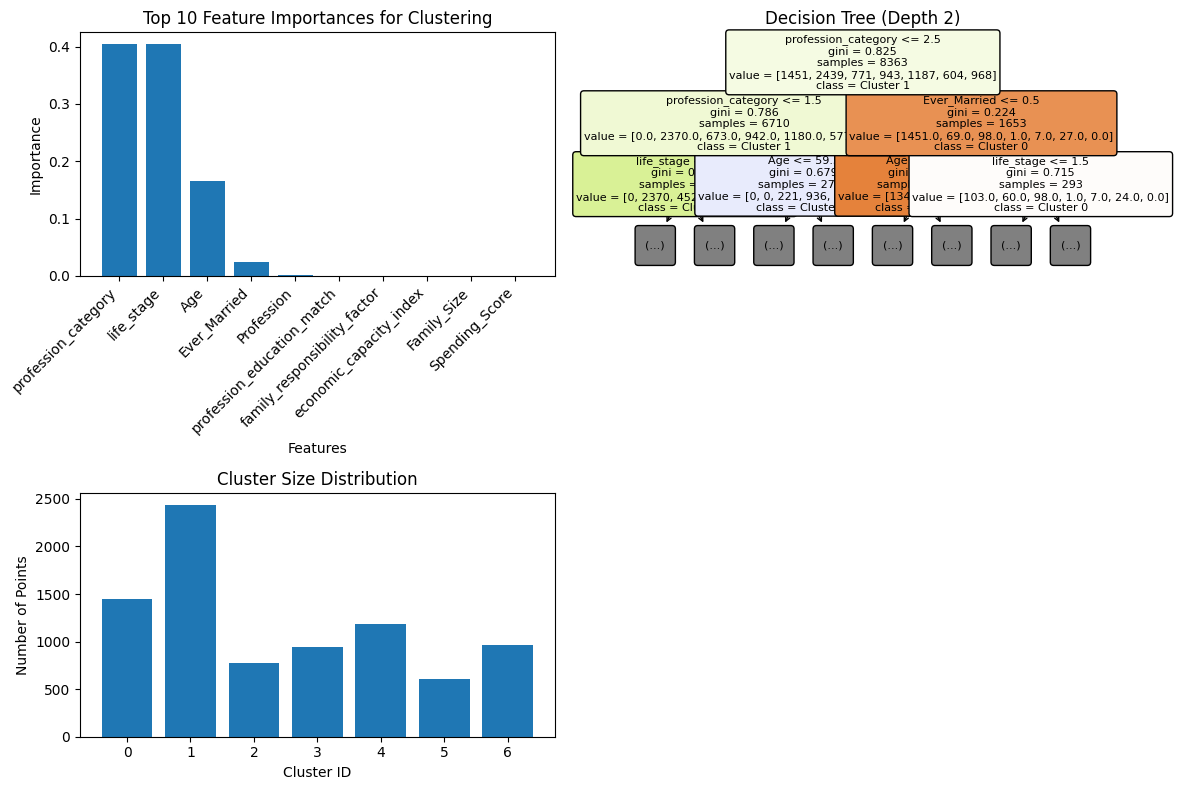

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


feature_names = [col for col in df_with_clusters.columns if col != "Cluster"]
# Train a decision tree to understand feature importance
df_with_clusters['Cluster'] = df_with_clusters['Cluster'] + 1
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(df_with_clusters[feature_names], df_with_clusters['Cluster'])

# Plot feature importance
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))

# Feature importance bar plot
plt.subplot(2, 2, 1)
plt.bar(range(min(10, len(importances))), importances[indices[:10]])
plt.title('Top 10 Feature Importances for Clustering')
plt.xlabel('Features')
plt.ylabel('Importance')
feature_labels = [feature_names[i] if i < len(feature_names) else f'Feature_{i}' for i in indices[:10]]
plt.xticks(range(min(10, len(importances))), feature_labels, rotation=45, ha='right')

# Decision tree visualization (simplified)
plt.subplot(2, 2, 2)
plot_tree(tree, max_depth=2, feature_names=feature_names[:len(feature_names)], 
            class_names=[f'Cluster {i}' for i in np.unique(labels)],
            filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree (Depth 2)')

# Cluster size distribution
plt.subplot(2, 2, 3)
cluster_counts = np.bincount(labels[labels >= 0])
cluster_ids = np.arange(len(cluster_counts))
plt.bar(cluster_ids, cluster_counts)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Points')

# Feature correlation with clusters
# plt.subplot(2, 2, 4)
# if len(feature_names) > 0:
#     # Calculate correlation between first few features and cluster assignments
#     correlations = []
#     for i in range(min(5, df_with_clusters.shape[1])):
#         corr = np.corrcoef(df_with_clusters[:, i], df_with_clusters['Cluster'])[0, 1]
#         correlations.append(abs(corr))
    
#     plt.bar(range(len(correlations)), correlations)
#     plt.title('Feature-Cluster Correlations')
#     plt.xlabel('Features')
#     plt.ylabel('|Correlation| with Clusters')
#     plt.xticks(range(len(correlations)), 
#                 [feature_names[i][:10] if i < len(feature_names) else f'F{i}' for i in range(len(correlations))], 
#                 rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [21]:
df_with_clusters.to_csv("../data/clus_kmeans.csv")